<a href="https://colab.research.google.com/github/AtakaNKuscu/Physics-Informed-Neural-Networks/blob/main/first_order_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [59]:
seed = 32
torch.manual_seed(seed)
np.random.seed(seed)

In [60]:
# Neural Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, t):
        return self.layers(t)



In [61]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [62]:
# Physics residual: y' + y = 1
def residual(t):
    t.requires_grad_(True)
    y = model(t)
    dy_dt = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    return dy_dt + y - 1

In [63]:
# Training pts
Nf = 200
t_f = torch.linspace(0, 5, Nf).view(-1,1).to(device)

# BC
t0 = torch.tensor([[0.0]]).to(device)
y0_true = torch.tensor([[0.0]]).to(device)

In [64]:
# For plotting
loss_history = []
epochs = 5000

t_test = torch.linspace(0, 5, 200).view(-1,1).to(device)
t_np = t_test.cpu().numpy()
y_true = 1 - np.exp(-t_np)

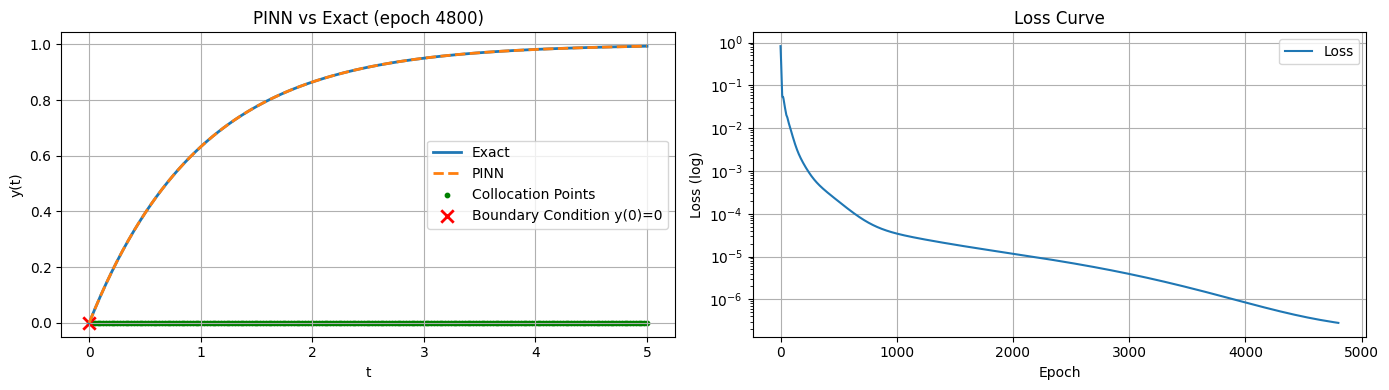

Training complete.


In [65]:
# Training Loop
for epoch in range(epochs):

    optimizer.zero_grad()

    # physics loss
    f = residual(t_f)
    loss_phys = torch.mean(f**2)

    # boundary loss
    y0 = model(t0)
    loss_bc = torch.mean((y0 - y0_true)**2)

    loss = loss_phys + loss_bc
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # visualization every N epochs
    if epoch % 200 == 0:
        clear_output(wait=True)

        # Predict current PINN solution
        y_pred = model(t_test).detach().cpu().numpy()

        # Create figure
        fig, axs = plt.subplots(1, 2, figsize=(14, 4))

        # ---- Plot 1: Exact vs PINN + BC + Collocation ----
        axs[0].plot(t_np, y_true, label="Exact", linewidth=2)
        axs[0].plot(t_np, y_pred, "--", label="PINN", linewidth=2)

        # Collocation points (t_f)
        axs[0].scatter(
            t_f.detach().cpu().numpy(),
            np.zeros_like(t_f.detach().cpu().numpy()),   # y-values aşağı koymak için
            s=10,
            color="green",
            label="Collocation Points"
        )

        # Boundary condition point
        axs[0].scatter(
            [0], [0],
            s=80, color="red", marker="x", linewidths=2,
            label="Boundary Condition y(0)=0"
        )

        axs[0].set_title(f"PINN vs Exact (epoch {epoch})")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("y(t)")
        axs[0].legend()
        axs[0].grid()

        # ---- Plot 2: Loss ----
        axs[1].plot(loss_history, label="Loss")
        axs[1].set_yscale("log")
        axs[1].set_title("Loss Curve")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss (log)")
        axs[1].grid()
        axs[1].legend()

        plt.tight_layout()
        plt.show()

print("Training complete.")
